# Introduction

Travelers and hosts around the world have used Airbnb to expand staying possibilities. It renders a unique and personalized way of experiencing the world and socializing with new people. You may have heard questions like “How to make your Airbnb home more attractive?” or “How to choose Airbnb home with tight budget?” The analysis could provide some insights on:
1. What descriptions tend to link to high price?
2. How do bed and bath counts affect the price?
3. How do neighborhoods affect the prices?

## Import packages and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

In [4]:
# import data to dataframes
list_df = pd.read_csv('listings.csv')
list_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


The following Airbnb activity is included in this Boston dataset:
1. descriptions
2. details of the listing such as bedroom, bathroom etc.
3. information about the host (superhost, with pic, with id veryfication)
4. information about the requirements (with pic, with name)
5. infomation about booking (cancellation, instant booking)
6. review scores

# EDA

In order to perform the data analysis, we first need to clean the data.

In [16]:
# Copy the dataframe
list_clean = list_df.copy()

In [17]:
# First, let's drop some columns that are not useful for analysis
cols = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'listing_url', 'host_url',
       'host_thumbnail_url', 'host_picture_url', 'country', 'country_code', 'neighbourhood',
       'smart_location', 'street', 'market', 'first_review', 'last_review', 'state', 'calendar_last_scraped',
       'calendar_updated', 'city', 'scrape_id', 'last_scraped', 'space', 'host_neighbourhood', 
        'neighborhood_overview', 'host_listings_count', 'zipcode', 'is_location_exact', 'host_location',
       'host_total_listings_count']
list_clean.drop(cols, axis=1, inplace=True)

In [18]:
# drop the colunms with more than half of the missing value
cols = list_clean.columns[list_clean.isnull().sum()/list_clean.shape[0] > 0.5]
list_clean.drop(cols, axis=1, inplace=True)

In [19]:
# We are going to use the price to predict, so drop any rows in price with missing value
list_clean.dropna(axis=0, subset=['price'], inplace=True)

In [20]:
# Next, let's fix some datatype errors, extract numbers and change to int type
cols = ['host_response_rate', 'host_acceptance_rate', 'price', 'cleaning_fee', 'extra_people']
for col in cols:
    list_clean[col] = list_clean[col].str.extract(r'(\d+)')
    list_clean[col] = list_clean[col].astype('float128').astype('Int64')
list_clean[cols].dtypes

host_response_rate      Int64
host_acceptance_rate    Int64
price                   Int64
cleaning_fee            Int64
extra_people            Int64
dtype: object

In [21]:
# Change datatype for host_since
list_clean['host_since'] = pd.to_datetime(list_clean.host_since)
temp = pd.to_datetime('12/31/2019')

In [22]:
list_clean['host_len'] = list_clean.host_since.apply(lambda x: pd.Timedelta(temp-x).days)
list_clean = list_clean.drop('host_since', axis=1)

I will separately clean the numerical and categorical columns, since the methods is a little bit different.

In [23]:
# extract the number of amenities 
list_clean['n_amenities'] = list_clean['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
list_clean.drop('amenities', axis=1, inplace=True)

In [24]:
df_num = list_clean.select_dtypes(include=['int', 'float'])

In [25]:
# fill na for the columns
int_fillmean = lambda x: x.fillna(round(x.mean()))
df_num = df_num.apply(int_fillmean, axis=0)
df_num = df_num.drop(['id', 'host_id', 'latitude', 'longitude'], axis=1).astype(float)

In [26]:
df_num.describe()

,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_len,n_amenities
count,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,...,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000
mean,94.990516,84.150349,3.041283,1.220781,1.255230,1.610042,168.511576,68.262762,1.429847,10.886192,...,9.332497,9.199163,9.727197,9.727197,9.319107,9.129707,12.733891,1.977043,2104.668340,15.862762
std,11.666206,20.297865,1.778929,0.500698,0.752129,1.010663,111.909788,42.646336,1.056787,19.137773,...,0.837804,1.032642,0.686118,0.662954,0.811975,0.890595,29.415076,1.883715,620.783376,4.832590
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.010000,1211.000000,1.000000
25%,95.000000,79.000000,2.000000,1.000000,1.000000,1.000000,85.000000,40.000000,1.000000,0.000000,...,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.640000,1653.000000,13.000000
50%,100.000000,91.000000,2.000000,1.000000,1.000000,1.000000,150.000000,68.000000,1.000000,0.000000,...,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,2.000000,1.910000,1975.000000,16.000000
75%,100.000000,100.000000,4.000000,1.000000,2.000000,2.000000,220.000000,80.000000,1.000000,20.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.000000,2.130000,2440.000000,19.000000
max,100.000000,100.000000,16.000000,6.000000,5.000000,16.000000,999.000000,300.000000,14.000000,200.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,136.000000,19.150000,4067.000000,31.000000


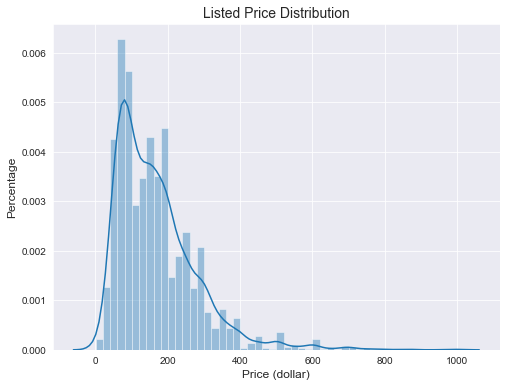

In [27]:
# visualizae the price
plt.figure(figsize=(8, 6))
sns.distplot(df_num['price'], bins=50, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price (dollar)', fontsize=12)
plt.title('Listed Price Distribution', fontsize=14);

In [28]:
# we can see that some listed price are 1 dollar, which is not intuitive
df_num = df_num[df_num['price'] != 1]

In [29]:
# we will also exlude some outliers of the price > 1.5 IQR
df_num = df_num[df_num['price'] < 423]

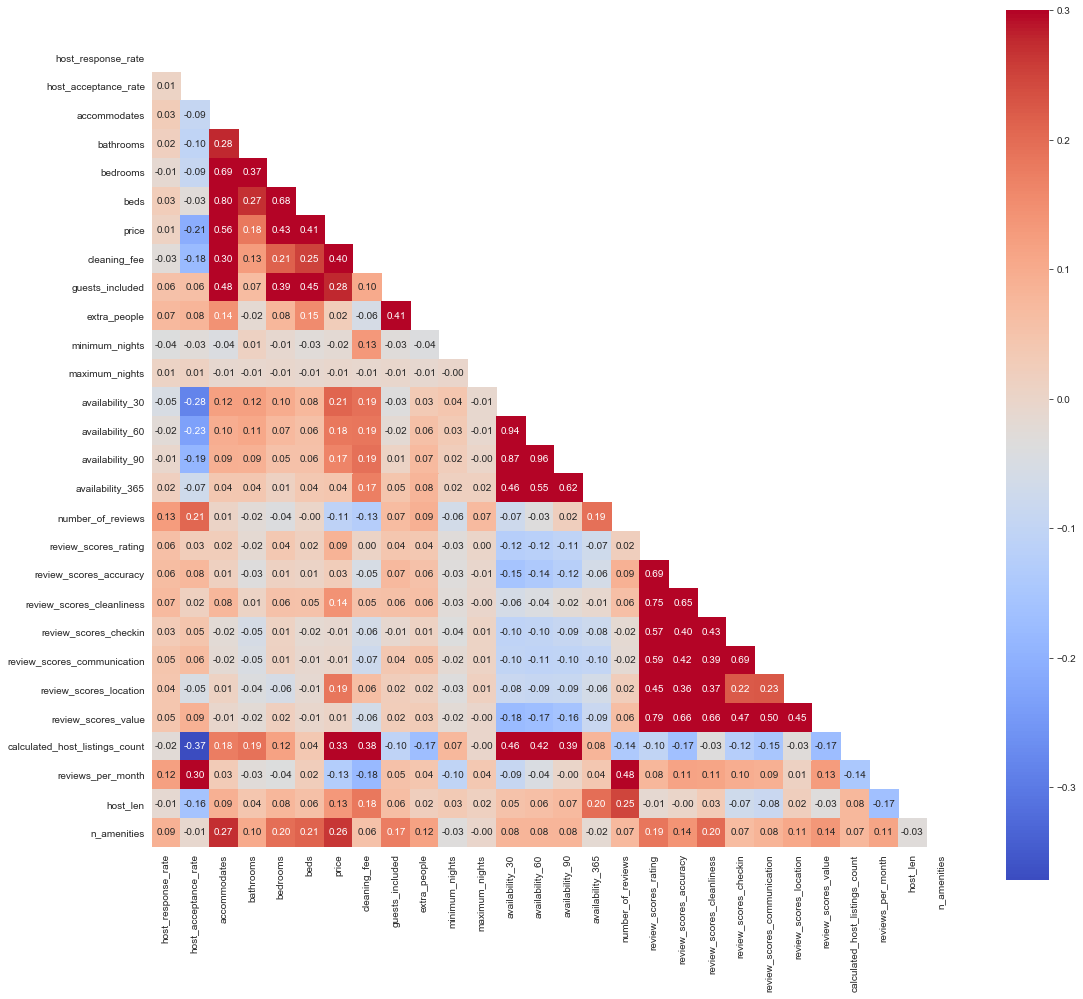

In [20]:
# visualize the correlation matrix
corr = df_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 16))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')

Since the bedroom and bathroom are numerical features. We will visualize the statistics to see how does these two factor affect the price. (**Question 2**)

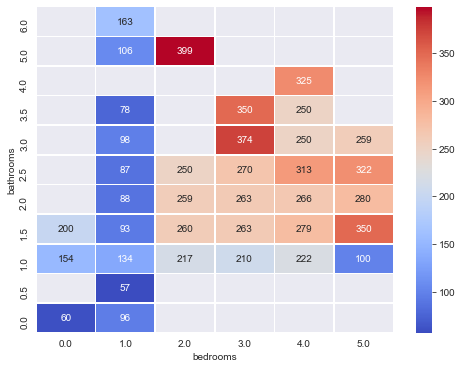

In [30]:
# visualizae the price
plt.figure(figsize=(8, 6))
sns.heatmap(df_num.groupby(['bathrooms', 'bedrooms']).mean()['price'].reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False),
            cmap="coolwarm", fmt='.0f', annot=True, linewidths=0.5);

We can see that, in general, as increase of beds/baths numbers, the price for listings goes higher.

In [31]:
# Next let's look at the categorical values
df_cat = list_clean.select_dtypes(include=['object'])

In [32]:
# we will drop few description lines for future analysis
df_cat = df_cat.drop(['name', 'summary', 'description', 'experiences_offered', 'host_about', 
                      'host_verifications', 'host_name'], axis=1)

I think interaction, house_rules, access can substantial the post. Maybe provide the information would attract more people and pontentially inrease the value of the house. Since there are a lot of missing values in these columns, I will just categorize them with t (with info) and f (without info). 

In [33]:
# find the not na rows with True
df_cat['with_inter'] = df_cat.interaction.notna().astype('object')
df_cat['with_access']= df_cat.access.notna().astype('object')
df_cat['with_rules'] = df_cat.house_rules.notna().astype('object')
df_cat['with_transit'] = df_cat.transit.notna().astype('object')
df_cat = df_cat.drop(['transit', 'access', 'interaction', 'house_rules'], axis=1)

In [34]:
df_cat = pd.concat([df_cat, list_clean.price], axis=1)
df_cat = df_cat[df_cat['price'] != 1]
df_cat = df_cat[df_cat['price'] < 423]


In [35]:
# get dummy values for categorical features
df_cat_dummies = pd.get_dummies(df_cat.iloc[:,:-1], dummy_na=False)

In [36]:
# concatenate the model df
df_mod = pd.concat([df_num, df_cat_dummies], axis=1)

# Popular Word and Word Cloud

We want to see that whether different price groups will have different styles of descriptions. In order to visulize, we will extract the description from the cleaned dataset. And extract the key words to compare the differences.

## Popular words

In [37]:
# We will first extract the dataframe for word analysis
df_word = list_clean.loc[:,['description', 'price']]
df_word = df_word[df_word.price!=1] 
df_word = df_word[df_word.price<423] 
df_word.sample(5)

,description,price
2263,Floor to ceiling windows provide scenic views ...,232
2583,Completely renovated home and fantastic locati...,69
1656,This is a cozy bedroom with INDIVIDUAL LOCK in...,44
2314,"Both elegant and modern, this apartment was de...",169
2033,"My place is close to Faneuil Hall Marketplace,...",10


In [38]:
# segment price into two groups 
bin_edges = [0, 84, 145, 205, 417]
bin_name = ['25%', '50%', '75%', '100%']
df_word['price_bin'] = pd.cut(df_word['price'], bins=bin_edges, labels=bin_name)

In [39]:
# get the post content for each price group
p_words = {};
for i in range(len(bin_name)):
    p_words[i] = ''
    df_i = df_word[df_word['price_bin'] == bin_name[i]]['description'].astype(str)
    for j in range(len(df_i)):
        words = df_i.iloc[j].split(' ')
        for word in words:
            p_words[i] += word+' '

In [40]:
# Get the most popular 20 words for each price group 
from collections import Counter
import string
counter = {}
occur = {}
stop_words = ['a', 'the', 'and', 'is', 'of', 'with', '', 'in', 'i', 'you', 'for', 'on', 'at', 'this', 'there', 
              'that', 'to', 'from', 'have', 'has', 'we', 'your', 'my', 'are', 'be', 'or', 'will', 'our', 'it',
             'located', 'all', 'as']
for i in range(len(bin_name)):
    words = p_words[i].lower().translate(str.maketrans('', '', string.punctuation)).split(' ')
    counter[i] = Counter([word for word in words if word not in stop_words])
    occur[i] = counter[i].most_common(20)
    
df1 = pd.DataFrame.from_dict(occur[0]).rename(columns={0:'word', 1:'count'})
df2 = pd.DataFrame.from_dict(occur[1]).rename(columns={0:'word', 1:'count'})
df3 = pd.DataFrame.from_dict(occur[2]).rename(columns={0:'word', 1:'count'})
df4 = pd.DataFrame.from_dict(occur[3]).rename(columns={0:'word', 1:'count'})

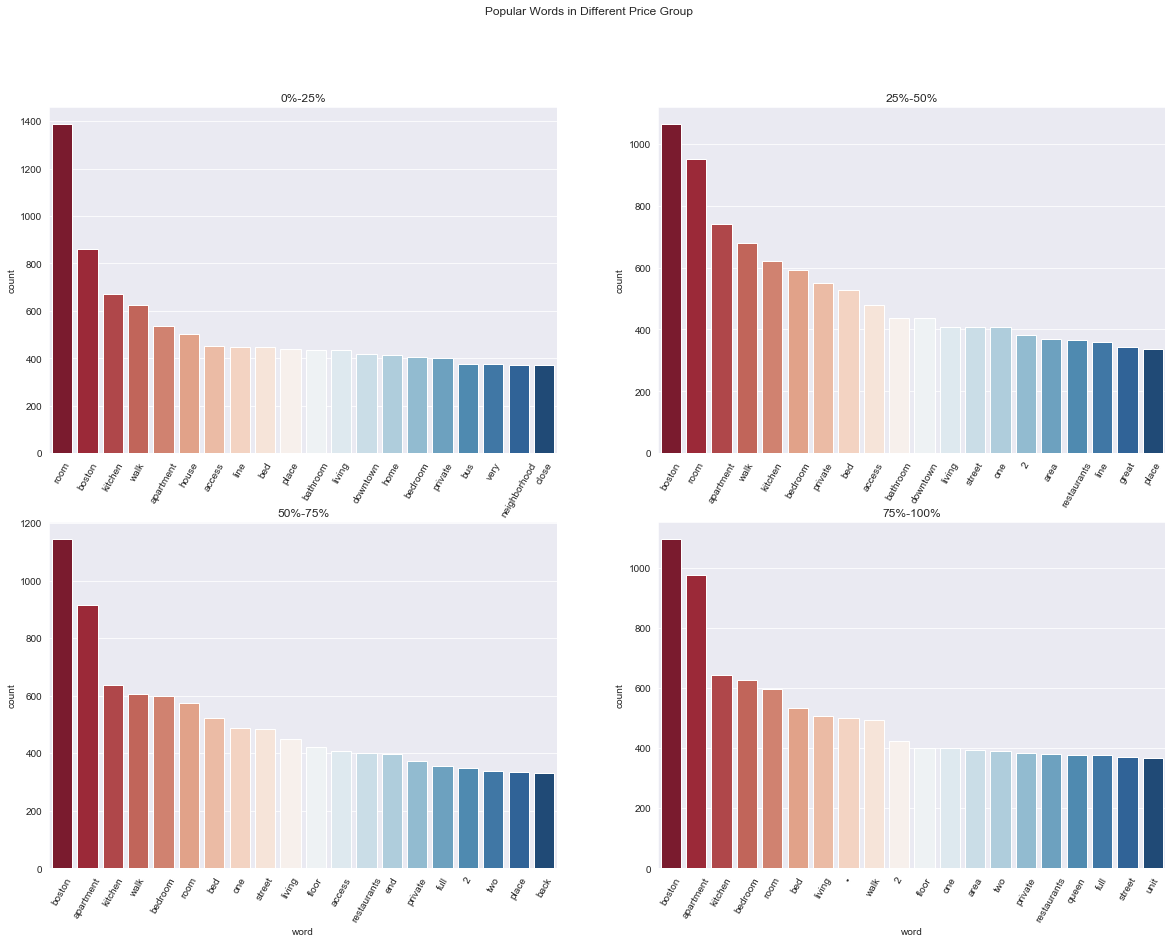

In [41]:
# visualization 
plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
ax1 = sns.barplot(data=df1, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('0%-25%', fontsize=12);

plt.subplot(2, 2, 2)
ax2 = sns.barplot(data=df2, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('25%-50%', fontsize=12)

plt.subplot(2, 2, 3)
ax2 = sns.barplot(data=df3, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.title('50%-75%', fontsize=12)

plt.subplot(2, 2, 4)
ax2 = sns.barplot(data=df4, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.title('75%-100%', fontsize=12)

plt.suptitle('Popular Words in Different Price Group');

There a a lot of overlapping in different price groups, one thing that is interesting is that the higher priced listings contains 'restuarants' more frequently, while lower price listings emphasize some transportation words such as 'bus' and 'line' (metro). 

## Word Cloud

Word Cloud is another way to look at the key words. It will generate a image of the key words which is very cool!

In [44]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(stop_words)

# Model Selection

To effect how exact neighbourhood and bed/bath counts affect the price. We first need to generate a model to predict the price.

### Feature selection and Linear model

There are a lot of features, we will first run a feature selection to select the best predictors.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [48]:
# get the feature and label
X = df_mod.drop('price', axis=1)
y = df_mod['price']

In [49]:
# There are two many features, let's select top 30 features with REF model
n = np.arange(5, 100, 5)
model = LinearRegression()
R2 = []
#Initializing RFE model
for num in n:
    rfe = RFE(model, num)
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X,y)  
    #Fitting the data to model
    model.fit(X_rfe,y)
    # generate new feature matrix
    X_new = X.iloc[:,rfe.support_]
    # split training and testing model
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
    # fit the data
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    pred = lm.predict(X_test)
    R2.append(metrics.r2_score(y_test, pred))

In [50]:
ind = np.array(R2).argmax()
f_n = n[ind]
rfe = RFE(model, f_n)
X_rfe = rfe.fit_transform(X,y) 
model.fit(X_rfe,y)
X_new = X.iloc[:,rfe.support_]
print('{} features are selected'.format(f_n))

95 features are selected


In [51]:
# split training and testing model
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [52]:
# fit the data
lm = LinearRegression()
lm.fit(X_train, y_train)
pred = lm.predict(X_test)

In [53]:
# evaluate
mse = metrics.mean_squared_error(y_test, pred)
r_square = metrics.r2_score(y_test, pred)

print('Mean absolute error is {}'.format(mse))
print('R^2 is {}'.format(r_square))

Mean absolute error is 2599.759883065742
R^2 is 0.6675173286542568


In [54]:
# create a function to visualize the distribution of the prediction and the test
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    """"
    This function returns a distribution plot of the predict label and actual label
    args: y test, y hat (pred), name of the variables, and title of the figure 
    return distribution of y test and y(hat)
    """
    plt.figure(figsize=(10, 8))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()

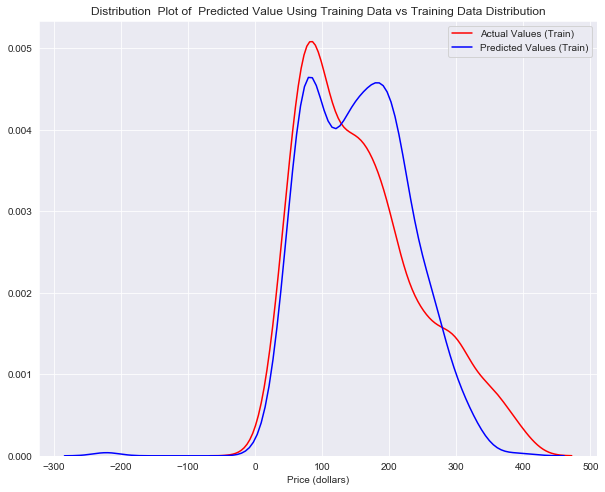

In [55]:
# Visualize the results
DistributionPlot(y_test, pred, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

## Ridge Regression

From the distribution figure above, we can see a little "dip" on the predicted price, maybe it's due to complexity of the model (too many features are selected). Hence, we will run a ridge regression to see whether we can optimize the model by decrease the complexity.

In [58]:
# screen ridge model
RR_square = []
RR_train = []
alpha = [0.0001, 0.001, 0.1, 1, 10, 20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RR_square.append(RigeModel.score(X_test, y_test))
    RR_train.append(RigeModel.score(X_train, y_train))

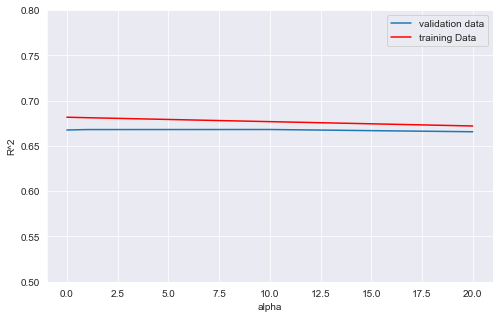

In [59]:
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RR_square, label='validation data')
plt.plot(alpha,RR_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0.5, 0.8)
plt.legend();

In [60]:
# Choose a ridge
RigeModel = Ridge(alpha=5) 
RigeModel.fit(X_train, y_train)
rr_pred = RigeModel.predict(X_test)
print('r2 score is: {}'.format(RigeModel.score(X_test, y_test)))

r2 score is: 0.6685482044775237


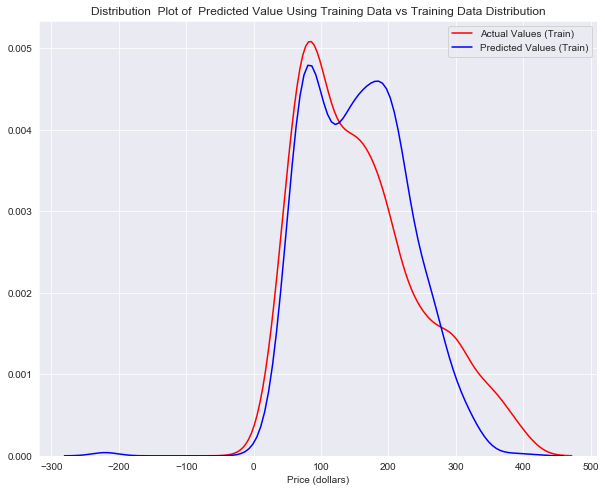

In [61]:
# Visualize the results
DistributionPlot(y_test, rr_pred, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

We can see that ridge only slightly improve the model...

# Conclustions

**Q1: What descriptions tend to link to high price?**

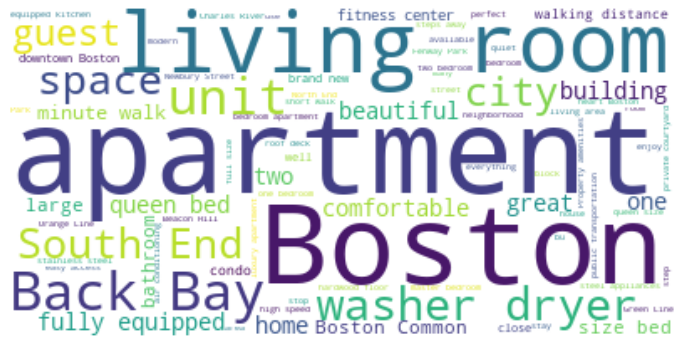

In [68]:
# generate word cloud for high price group
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3,contour_color='firebrick', 
                      stopwords = stopwords)

wordcloud.generate(p_words[3])
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

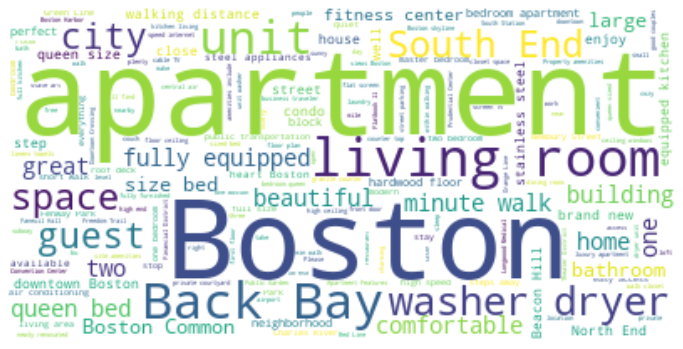

In [69]:
# generate word cloud for high price group
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3,contour_color='firebrick', 
                      stopwords = stopwords)

wordcloud.generate(p_words[3])
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The more expensive listings tend to put information about the neighborhoods, and amenities. For example: washer and dryer, fully-equipped, queen bed and fitness center.
The cheaper listings provide more information about the space description. For example: large, cozy, private, and spacious.

In [62]:
coef_df = pd.DataFrame(data=list(lm.coef_), index=X_new.columns).reset_index().rename(columns={'index': 'Var', 0: 'Coef'})

**Q2: How do bed and bath affect the price?**

In [65]:
print(coef_df.iloc[3:5, :])

         Var       Coef
3  bathrooms   2.356966
4   bedrooms  28.753938


**Every additional bedroom will cost extra 28.5 dollars, while each additional bathroom will cost extra 2.3 dollars.**

**Q3: How do neighborhood affect the price**

In [66]:
# get the neighboorhood
neighborhoods = coef_df[coef_df.Var.str.contains('neighbourhood')].sort_values(by='Coef', ascending=False)
neighborhoods['Var'] = neighborhoods['Var'].apply(lambda x: x.split('_')[2])

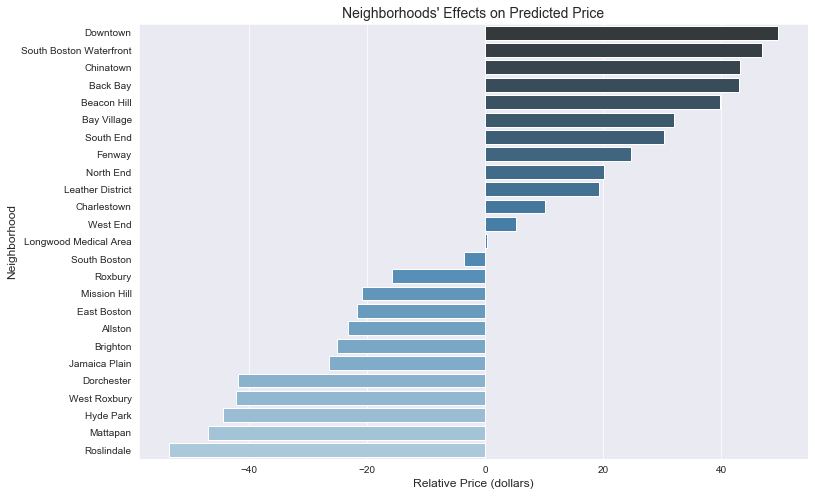

In [67]:
# Visualize neighborhood effect on price
plt.figure(figsize=(12, 8))
sns.barplot(data=neighborhoods, x='Coef', y='Var', palette='Blues_d')
plt.xlabel('Relative Price (dollars)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title("Neighborhoods' Effects on Predicted Price", fontsize=14);

Undoubtedly, **neighborhood is an important factor when pricing the listings.** Depends on where you choose to stay, the price can vary quite a bit. Far-from-the-city-center, neighborhoods like Mattapan, Dorchester, Jamaica Plain cost 40 dollars or less than average to rent in.

This dataset can be used to answer a lot more questions, some interesting findings includes:
1. Real bed costs more than alternative options.

2. Superhosts' listings are 6 dollars more expensive on average. 

3. Property types strongly affect the price. For example: a camp/RV will cost 150 dollars less on average but a boat will cost 39.7 dollars more on average.

4. Entire room on average will cost 76.6 more than a shared-room.

5. In general, the more strict the cacellation policy is, the more expensive the listing will be. Maybe listings have strict cancellation policy are tend to be more expensive and popular. 